In [1]:
import torch
import triton
import triton.language as tl
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}
$$

In [2]:
def naive_softmax(x):
    # reads MN elements and write M elements
    x_max = x.max(dim=1)[0] # shape (M) - grab only the maxes
    # read MN + M elements, subtraction is MN flops, write MN elements
    z = x - x_max[:, None] # shape (M, N) - shape (M, 1) = shape (M, N)

    # reading MN elements and writing MN elements
    numerator = torch.exp(z) # shape (M, N)

    # read MN elements, then MN flops, write M elements
    denominator = numerator.sum(1) # shape (M, N) -> shape (M)

    # read MN + M elements, division MN flops, write MN elements
    out = numerator / denominator[:, None] # shape (M, N) / shape (M, 1) = shape (M, N)

    # in total 8MN + 4M operations
    return out

The goal is instead to read MN only once and write once, meaning we only have MN and the rest are done on DRAM.

In [3]:
def test_softmax_kernel(size: tuple, atol=1e-3, rtol=1e-2, device=DEVICE):
    torch.manual_seed(0)
    x = torch.randn(size[0], size[1], device=DEVICE)

    z_tri = softmax(x)
    z_ref = torch.softmax(x, axis=1)

    torch.testing.assert_close(z_tri, z_ref, atol=atol, rtol=rtol)
    print("PASSED")

In [4]:
properties = triton.runtime.driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
TOTAL_SRAM_PER_SM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]

print(properties)

{'max_shared_mem': 101376, 'max_num_regs': 65536, 'multiprocessor_count': 36, 'warpSize': 32, 'sm_clock_rate': 1605000, 'mem_clock_rate': 8001000, 'mem_bus_width': 128}


In [5]:
def softmax(x):
    assert x.ndim == 2
    assert x.is_contiguous()
    
    n_rows, n_cols = x.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    num_stages = 4 if TOTAL_SRAM_PER_SM > 200_000 else 2

    y = torch.empty_like(x)

    # Warmup, precompile kernel
    kernel = _softmax_kernel.warmup(
        x, y,
        x.stride(0), y.stride(0),
        n_rows, n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
        num_stages=num_stages,
        num_warps=num_warps,
        grid=(1,)
    )
    kernel._init_handles()
    n_regs_per_program = kernel.n_regs
    sram_needed_per_program = kernel.metadata.shared

    reg_occupancy = NUM_REGS // (n_regs_per_program * WARP_SIZE * num_warps)
    # NUM_REGS = 65536
    # Each program might use
        # n_regs_per_program = 32
        # WARP_SIZE = 32
        # num_warps = 8
    # so, each program needs (n_regs_per_program * WARP_SIZE * num_warps) registers toatl
    # 65536//(32 * 32 * 8) = 8 program per SM

    sram_occupancy = TOTAL_SRAM_PER_SM // sram_needed_per_program
    
    programs_per_sm = min(reg_occupancy, sram_occupancy) # choose the limiting occupancy

    num_programs = min(NUM_SM * programs_per_sm, n_rows) # handle fewer rows than programs needed

    grid = (num_programs, 1, 1)

    kernel[grid](
        x, y,
        x.stride(0), y.stride(0),
        n_rows, n_cols,
        BLOCK_SIZE,
        num_stages
    )

    return y

In [6]:
@triton.jit
def _softmax_kernel(
    input_ptr, output_ptr,
    input_row_stride, output_row_stride,
    n_rows, n_cols, 
    BLOCK_SIZE: tl.constexpr,
    num_stages: tl.constexpr,
):
    # shape (M, N)
    # BLOCK_SIZE = next power of 2 bigger than N, fitting an entire row into SRAM at a time
    # each PID is going to start a different row

    PID = tl.program_id(0)
    row_step = tl.num_programs(0) # handle more rows than can be run at a time

    for row_idx in tl.range(PID, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + (row_idx * input_row_stride)
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets   # bunch of elements of our input tensor
        mask = col_offsets < n_cols                # limit access to overwriting rows
        row = tl.load(input_ptrs, mask=mask, other=float('-inf')) # shape (BLOCK_SIZE) ~= shape (n_cols)
            # only memory read

        row_minus_max = row - tl.max(row, axis=0) # shape (BLOCK_SIZE) - (1) -> (BLOCK_SIZE)
        numerator = tl.exp(row_minus_max)         # shape (BLOCK_SIZE)
        denominator = tl.sum(numerator, axis=0)   # shape (1)
        softmax_output = numerator / denominator  # shape (BLOCK_SIZE) / (1) -> (BLOCK_SIZE)

        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + col_offsets, softmax_output, mask=mask)
        

In [11]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128*i for i in range(2, 30)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="softmax-performance",
        args={'M': 4096}
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)

    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x)) 

    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)

In [14]:
test_softmax_kernel(size=(1000, 452))

PASSED


softmax-performance:
         N      Triton       Torch
0    256.0   58.935253  198.620693
1    384.0  186.790865  211.239964
2    512.0  190.382117  213.237792
3    640.0  195.397229  222.781155
4    768.0  190.880452  214.395831
5    896.0  194.693286  218.692357
6   1024.0  197.738587  221.625113
7   1152.0  198.008912  221.602446
8   1280.0   16.873327    7.616922
9   1408.0    8.876281    7.678255
10  1536.0    8.001102    6.953750
11  1664.0    8.134744    7.511356
12  1792.0    7.811954    7.024094
13  1920.0    7.836917    7.013788
14  2048.0    7.718472    6.884034
15  2176.0    7.928243    9.418060
16  2304.0    7.775031    9.081592
17  2432.0    7.783081    8.505355
18  2560.0    7.786610    8.880965
19  2688.0    7.699593    8.425713
20  2816.0   17.976967  221.658076
21  2944.0  211.495441  222.648152
22  3072.0  213.028684   17.530137
23  3200.0   14.599372    7.940077
24  3328.0   14.497141    8.219186
25  3456.0    7.965141    8.114462
26  3584.0    7.608080    8.173609

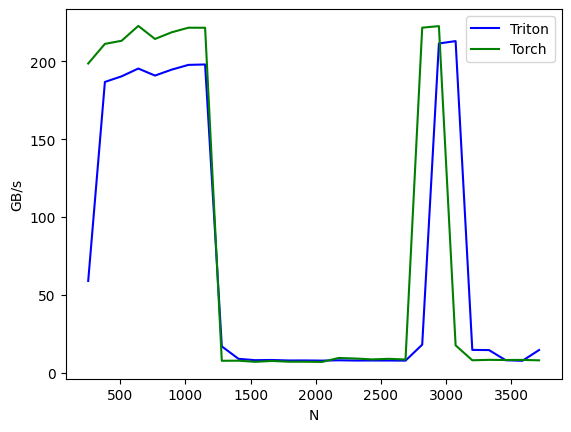

In [15]:
benchmark.run(save_path='.', print_data=True)